# Methylation data from Nanopolish HGSVC3

Intersected G4 annotationas from specific haplotype and matched it to methylation file from Nanopolish

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

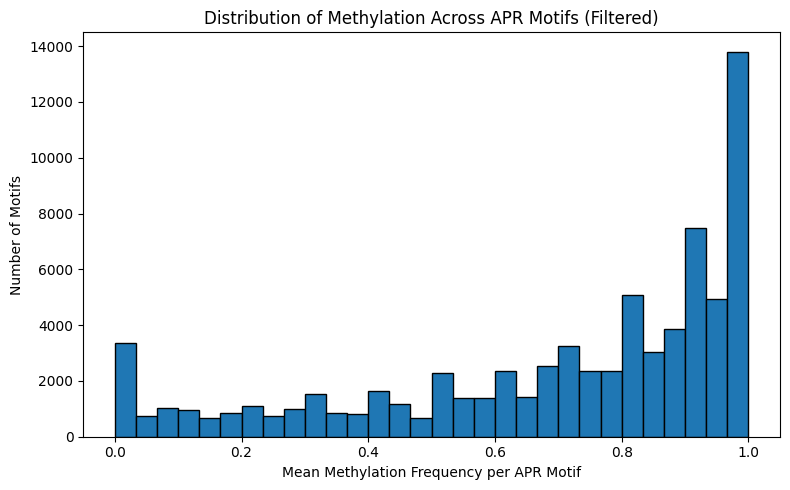

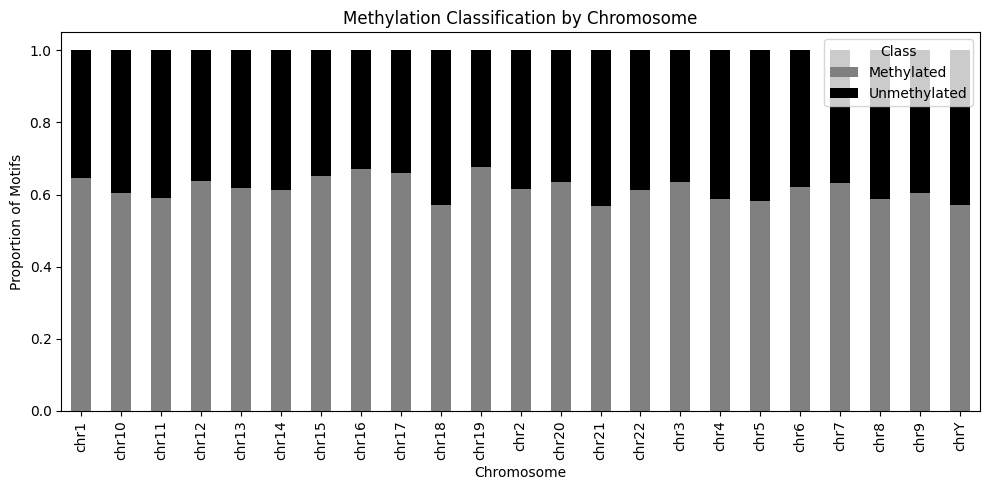

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# === Step 1: Load Data ===
apr_file = "/home/alextu/scratch/methylation_data/results/all_haps_results/HG00096_hap1/APR_methylation_intersect.tsv"
df = pd.read_csv(apr_file, sep="\t", header=None)

# === Step 2: Assign Column Names ===
df.columns = [
    "motif_chrom", "motif_start", "motif_end",
    "meth_chrom", "meth_start", "meth_end",
    "num_cpgs", "called_sites", "called_sites_methylated",
    "methylated_freq", "group_sequence"
]

# === Step 3: Group by Motif ===
grouped = df.groupby(["motif_chrom", "motif_start", "motif_end"])

# === Step 4: Compute summary stats per motif ===
summary_df = grouped.agg(
    num_cpg_groups=('methylated_freq', 'count'),
    mean_meth_freq=('methylated_freq', 'mean'),
    total_called_sites=('called_sites', 'sum'),
    total_methylated_sites=('called_sites_methylated', 'sum'),
    chrom=('motif_chrom', 'first')
).reset_index()

# === Step 5: Filter motifs with low coverage ===
min_sites = 10
filtered_df = summary_df[summary_df["total_called_sites"] >= min_sites].copy()

# === Step 6: Classify Motifs ===
methylation_threshold = 0.7
filtered_df["methylation_class"] = filtered_df["mean_meth_freq"].apply(
    lambda x: "Methylated" if x >= methylation_threshold else "Unmethylated"
)

# === Plot 1: Histogram of mean methylation frequency
plt.figure(figsize=(8, 5))
plt.hist(filtered_df["mean_meth_freq"], bins=30, edgecolor='black')
plt.xlabel("Mean Methylation Frequency per APR Motif")
plt.ylabel("Number of Motifs")
plt.title("Distribution of Methylation Across APR Motifs (Filtered)")
plt.tight_layout()
plt.show()

# === Plot 5: Stacked barplot of methylation class per chromosome
chrom_class_counts = filtered_df.groupby(["chrom", "methylation_class"]).size().unstack(fill_value=0)
chrom_class_props = chrom_class_counts.div(chrom_class_counts.sum(axis=1), axis=0)

chrom_class_props.plot(kind="bar", stacked=True, figsize=(10, 5), color=["grey", "black"])
plt.xlabel("Chromosome")
plt.ylabel("Proportion of Motifs")
plt.title("Methylation Classification by Chromosome")
plt.legend(title="Class", loc="upper right")
plt.tight_layout()
plt.show()

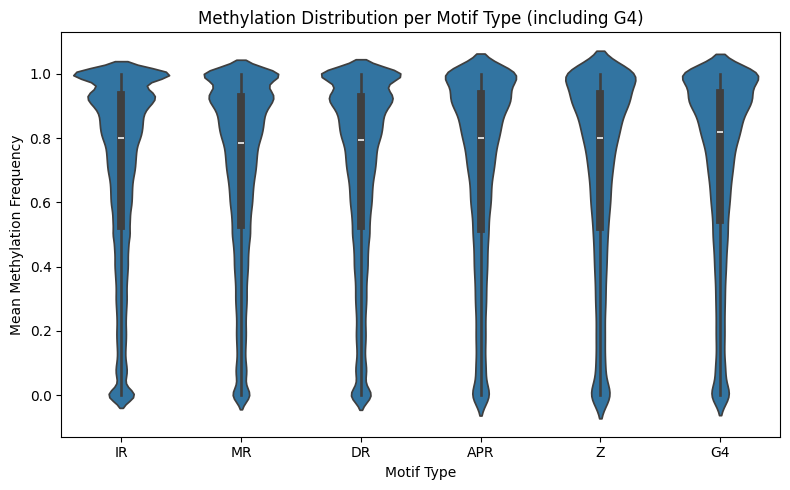

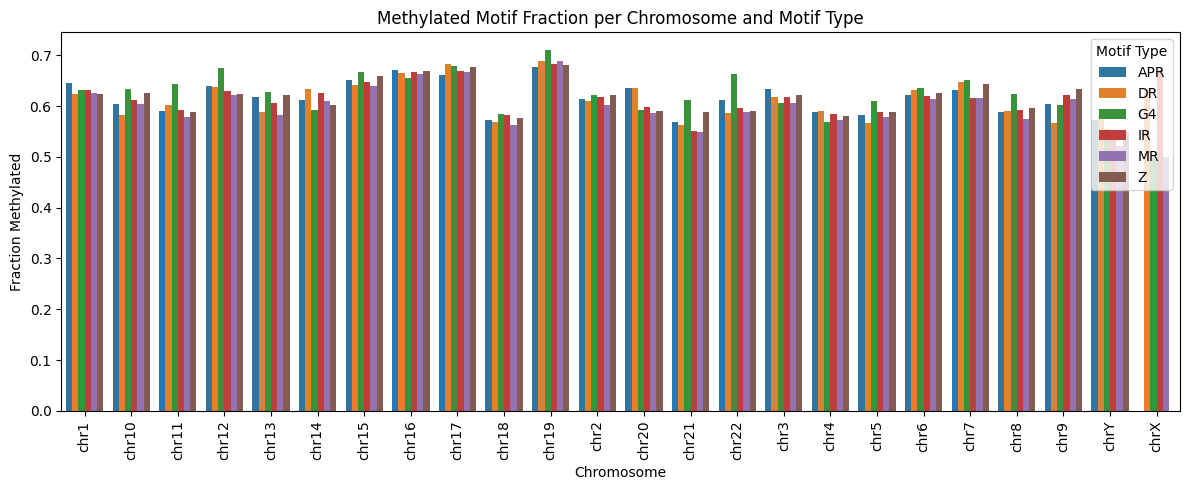

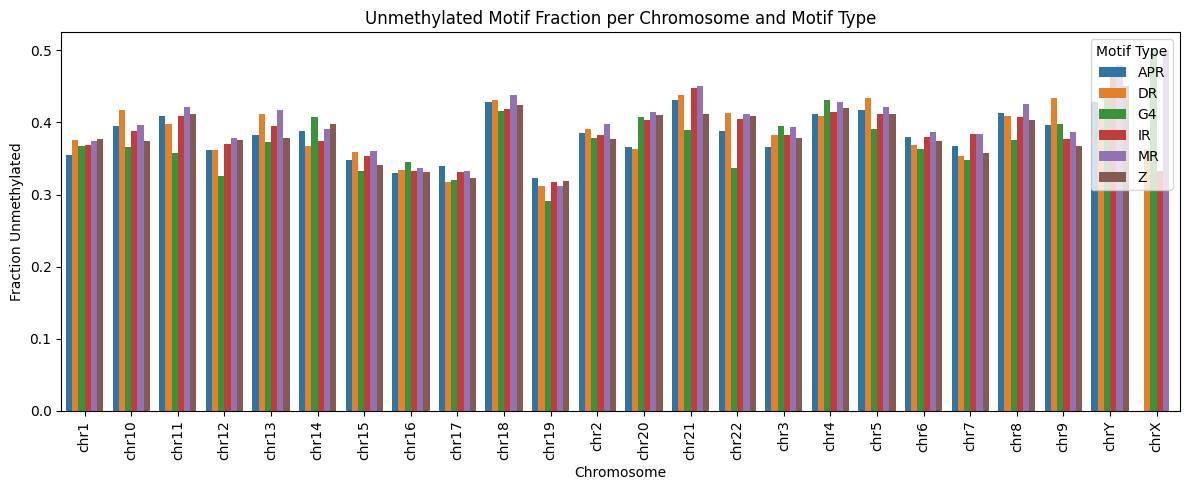

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# === Constants ===
motif_types = ["IR", "MR", "DR", "APR", "Z", "G4"]
min_sites = 10
methylation_threshold = 0.7

# === Master list to collect data ===
all_data = []

for motif in motif_types:
    file_path = f"/home/alextu/scratch/methylation_data/results/all_haps_results/HG00096_hap1/{motif}_methylation_intersect.tsv"
    
    if not os.path.exists(file_path):
        print(f"File not found for {motif}, skipping.")
        continue

    # Step 1: Load and label
    df = pd.read_csv(file_path, sep="\t", header=None)

    if motif == "G4":
        df.columns = [
            "motif_chrom", "motif_start", "motif_end", "Q",
            "meth_chrom", "meth_start", "meth_end",
            "num_cpgs", "called_sites", "called_sites_methylated",
            "methylated_freq", "group_sequence"
        ]
    else:
        df.columns = [
            "motif_chrom", "motif_start", "motif_end",
            "meth_chrom", "meth_start", "meth_end",
            "num_cpgs", "called_sites", "called_sites_methylated",
            "methylated_freq", "group_sequence"
        ]
    
    df["motif_type"] = motif

    # Step 2: Group and summarize
    grouped = df.groupby(["motif_chrom", "motif_start", "motif_end"])
    summary = grouped.agg(
        num_cpg_groups=('methylated_freq', 'count'),
        mean_meth_freq=('methylated_freq', 'mean'),
        total_called_sites=('called_sites', 'sum'),
        chrom=('motif_chrom', 'first')
    ).reset_index()

    # Step 3: Filter and classify
    summary = summary[summary["total_called_sites"] >= min_sites].copy()
    summary["methylation_class"] = summary["mean_meth_freq"].apply(
        lambda x: "Methylated" if x >= methylation_threshold else "Unmethylated"
    )
    summary["motif_type"] = motif

    # Collect
    all_data.append(summary)

# === Combine all motifs
combined_df = pd.concat(all_data, ignore_index=True)

# === Plot 1: Violin plot of mean methylation by motif type
plt.figure(figsize=(8, 5))
sns.violinplot(data=combined_df, x="motif_type", y="mean_meth_freq", inner="box")
plt.ylabel("Mean Methylation Frequency")
plt.xlabel("Motif Type")
plt.title("Methylation Distribution per Motif Type (including G4)")
plt.tight_layout()
plt.show()

# === Prep for Plot 2 & 3: Methylated and Unmethylated fractions per chrom+motif type
chrom_class_counts = combined_df.groupby(["motif_type", "chrom", "methylation_class"]).size().unstack(fill_value=0)
chrom_class_props = chrom_class_counts.div(chrom_class_counts.sum(axis=1), axis=0)

# Reformat for seaborn
chrom_class_props = chrom_class_props.reset_index().melt(
    id_vars=["motif_type", "chrom"],
    value_vars=["Methylated", "Unmethylated"],
    var_name="class", value_name="fraction"
)

# === Plot 2: Methylated fraction
methylated = chrom_class_props[chrom_class_props["class"] == "Methylated"]
plt.figure(figsize=(12, 5))
sns.barplot(data=methylated, x="chrom", y="fraction", hue="motif_type", errorbar=None)
plt.title("Methylated Motif Fraction per Chromosome and Motif Type")
plt.xlabel("Chromosome")
plt.ylabel("Fraction Methylated")
plt.xticks(rotation=90)
plt.legend(title="Motif Type")
plt.tight_layout()
plt.show()

# === Plot 3: Unmethylated fraction
unmethylated = chrom_class_props[chrom_class_props["class"] == "Unmethylated"]
plt.figure(figsize=(12, 5))
sns.barplot(data=unmethylated, x="chrom", y="fraction", hue="motif_type", errorbar=None)
plt.title("Unmethylated Motif Fraction per Chromosome and Motif Type")
plt.xlabel("Chromosome")
plt.ylabel("Fraction Unmethylated")
plt.xticks(rotation=90)
plt.legend(title="Motif Type")
plt.tight_layout()
plt.show()

processing HG01890_hap1
processing NA19705_hap1
processing HG01596_hap2
processing NA19384_hap1
processing HG00512_hap2
processing HG03732_hap1
processing HG03009_hap1
processing NA19836_hap1
processing HG03065_hap1
processing NA18534_hap1
processing NA19384_hap2
processing NA19434_hap2
processing NA19239_hap1
processing NA18989_hap2
processing HG04217_hap1
processing NA19836_hap2
processing HG03371_hap2
processing HG03371_hap1
processing HG01457_hap1
processing HG02666_hap2
processing HG03807_hap2
processing HG03065_hap2
processing NA19705_hap2
processing NA19650_hap2
processing HG00268_hap2
processing HG03248_hap1
processing NA19331_hap2
processing HG03009_hap2
processing HG01890_hap2
processing HG00096_hap1
processing NA19317_hap2
processing HG00096_hap2
processing HG00733_hap1
processing HG00512_hap1
processing HG03456_hap2
processing HG04217_hap2
processing HG00268_hap1
processing HG03456_hap1
processing HG02666_hap1
processing HG03248_hap2
processing NA18534_hap2
processing HG014

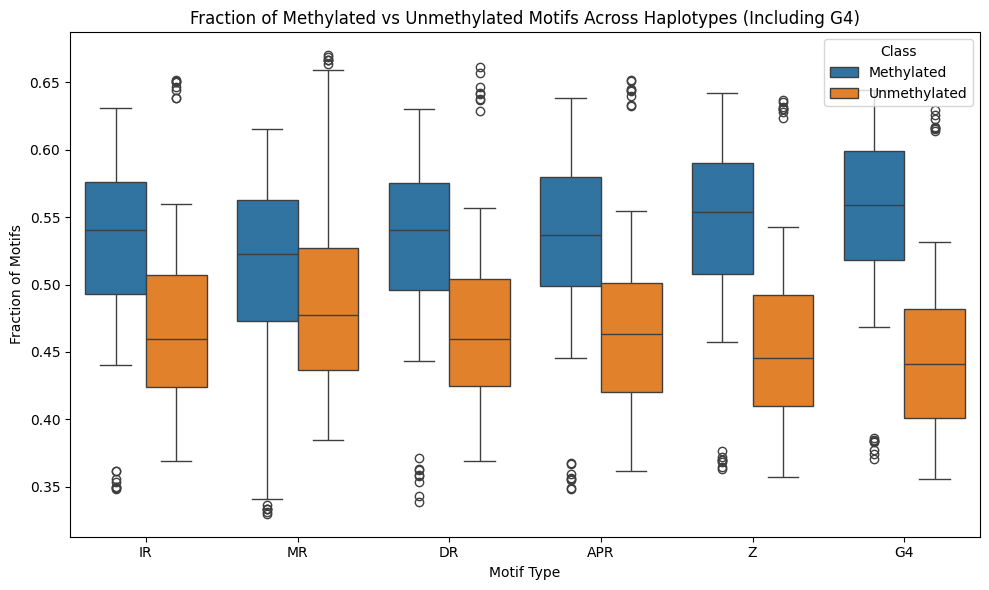

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# === Constants ===
base_dir = "/home/alextu/scratch/methylation_data/results/all_haps_results"
motif_types = ["IR", "MR", "DR", "APR", "Z", "G4"]
haplotypes = ["hap1", "hap2"]
min_sites = 10
methylation_threshold = 0.7

# === Discover haplotype directories (e.g., HG00096_hap1, HG00096_hap2) ===
hap_dirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d)) and d.endswith(("hap1", "hap2"))]

# === Master list to collect per-haplotype stats ===
results = []

for hap_dir in hap_dirs:
    print("processing", hap_dir)
    hap_path = os.path.join(base_dir, hap_dir)
    haplotype_id = hap_dir  # e.g., HG00096_hap1

    for motif in motif_types:
        file_path = os.path.join(hap_path, f"{motif}_methylation_intersect.tsv")
        if not os.path.exists(file_path):
            continue

        # === Load file with correct columns, handle empty files ===
        try:
            df = pd.read_csv(file_path, sep="\t", header=None)
            if df.empty:
                print(f"{file_path} is empty, skipping.")
                continue
        except pd.errors.EmptyDataError:
            print(f"{file_path} is unreadable or empty, skipping.")
            continue

        if motif == "G4":
            df.columns = [
                "motif_chrom", "motif_start", "motif_end", "Q",
                "meth_chrom", "meth_start", "meth_end",
                "num_cpgs", "called_sites", "called_sites_methylated",
                "methylated_freq", "group_sequence"
            ]
        else:
            df.columns = [
                "motif_chrom", "motif_start", "motif_end",
                "meth_chrom", "meth_start", "meth_end",
                "num_cpgs", "called_sites", "called_sites_methylated",
                "methylated_freq", "group_sequence"
            ]

        # === Group and summarize ===
        group_cols = ["motif_chrom", "motif_start", "motif_end"]
        grouped = df.groupby(group_cols)
        summary = grouped.agg(
            mean_meth_freq=('methylated_freq', 'mean'),
            total_called_sites=('called_sites', 'sum')
        ).reset_index()

        # === Filter and classify ===
        filtered = summary[summary["total_called_sites"] >= min_sites].copy()
        if filtered.empty:
            continue

        filtered["class"] = filtered["mean_meth_freq"].apply(
            lambda x: "Methylated" if x >= methylation_threshold else "Unmethylated"
        )

        counts = filtered["class"].value_counts(normalize=True)
        for cls in ["Methylated", "Unmethylated"]:
            results.append({
                "haplotype": haplotype_id,
                "motif_type": motif,
                "class": cls,
                "fraction": counts.get(cls, 0.0)
            })

# === Final dataframe for plotting ===
fraction_df = pd.DataFrame(results)
fraction_df.to_csv("haplotype_methylation_percentages.csv")

# === Plot: Boxplot of methylated/unmethylated fractions by motif ===
plt.figure(figsize=(10, 6))
sns.boxplot(data=fraction_df, x="motif_type", y="fraction", hue="class")
plt.xlabel("Motif Type")
plt.ylabel("Fraction of Motifs")
plt.title("Fraction of Methylated vs Unmethylated Motifs Across Haplotypes (Including G4)")
plt.legend(title="Class")
plt.tight_layout()
plt.show()

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === Step 1: Load methylation CSV
meth_file = "/home/alextu/projects/def-sushant/alextu/PhasedHapAssembly-nonB/analysis_scripts/haplotype_methylation_percentages.csv"
meth_df = pd.read_csv(meth_file)

# Extract sample ID (e.g., HG01890 from HG01890_hap1)
meth_df["sample"] = meth_df["haplotype"].str.extract(r"(HG\d+|NA\d+)")

# === Step 2: Load metadata TSV
meta_file = "/home/alextu/scratch/igsr_samples.tsv"
meta_df = pd.read_csv(meta_file, sep="\t")

# Rename to match
meta_df.rename(columns={"Sample name": "sample"}, inplace=True)

# === Step 3: Merge on sample
merged = pd.merge(meth_df, meta_df, on="sample", how="inner")

# === Step 3.5: Print South Asian 'methylated' samples with fraction > 0.6 ===
sas_meth = merged[
    (merged["Superpopulation name"] == "South Asian Ancestry") &
    (merged["class"] == "Unmethylated") &
    (merged["fraction"] > 0.6)
]

print(f"\nSouth Asian methylated samples with fraction > 0.6: ({len(sas_meth)} samples)")
print(sas_meth[["sample", "haplotype", "fraction"]].to_string(index=False))


South Asian methylated samples with fraction > 0.6: (12 samples)
 sample    haplotype  fraction
HG03009 HG03009_hap1  0.638152
HG03009 HG03009_hap1  0.657555
HG03009 HG03009_hap1  0.636957
HG03009 HG03009_hap1  0.640318
HG03009 HG03009_hap1  0.628265
HG03009 HG03009_hap1  0.614193
HG03009 HG03009_hap2  0.638345
HG03009 HG03009_hap2  0.659130
HG03009 HG03009_hap2  0.628746
HG03009 HG03009_hap2  0.632361
HG03009 HG03009_hap2  0.623794
HG03009 HG03009_hap2  0.626058


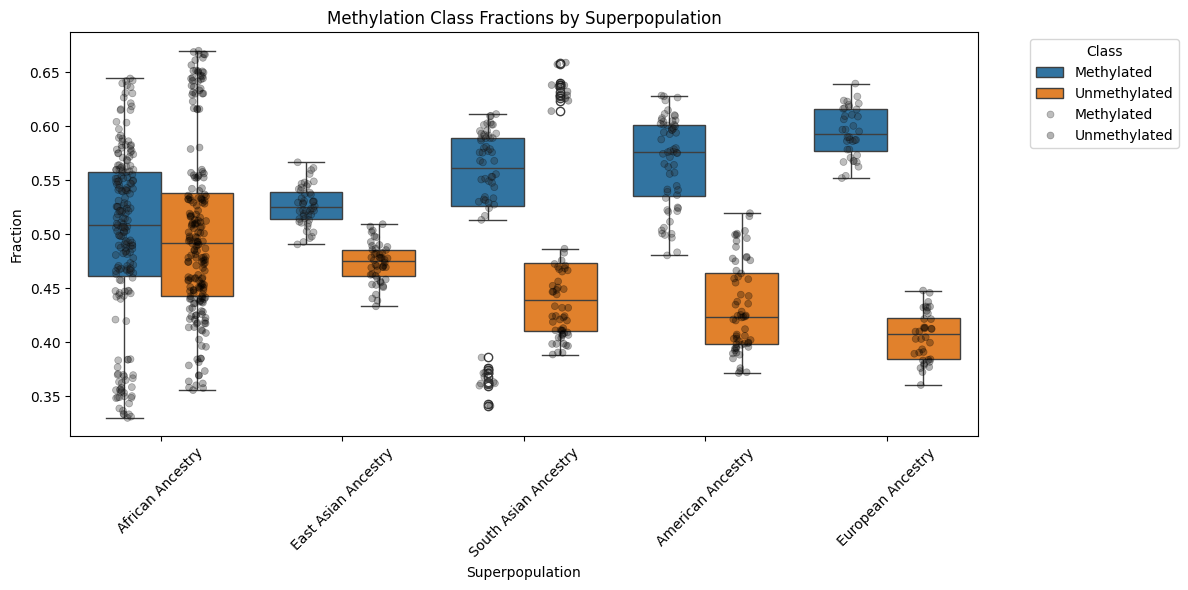

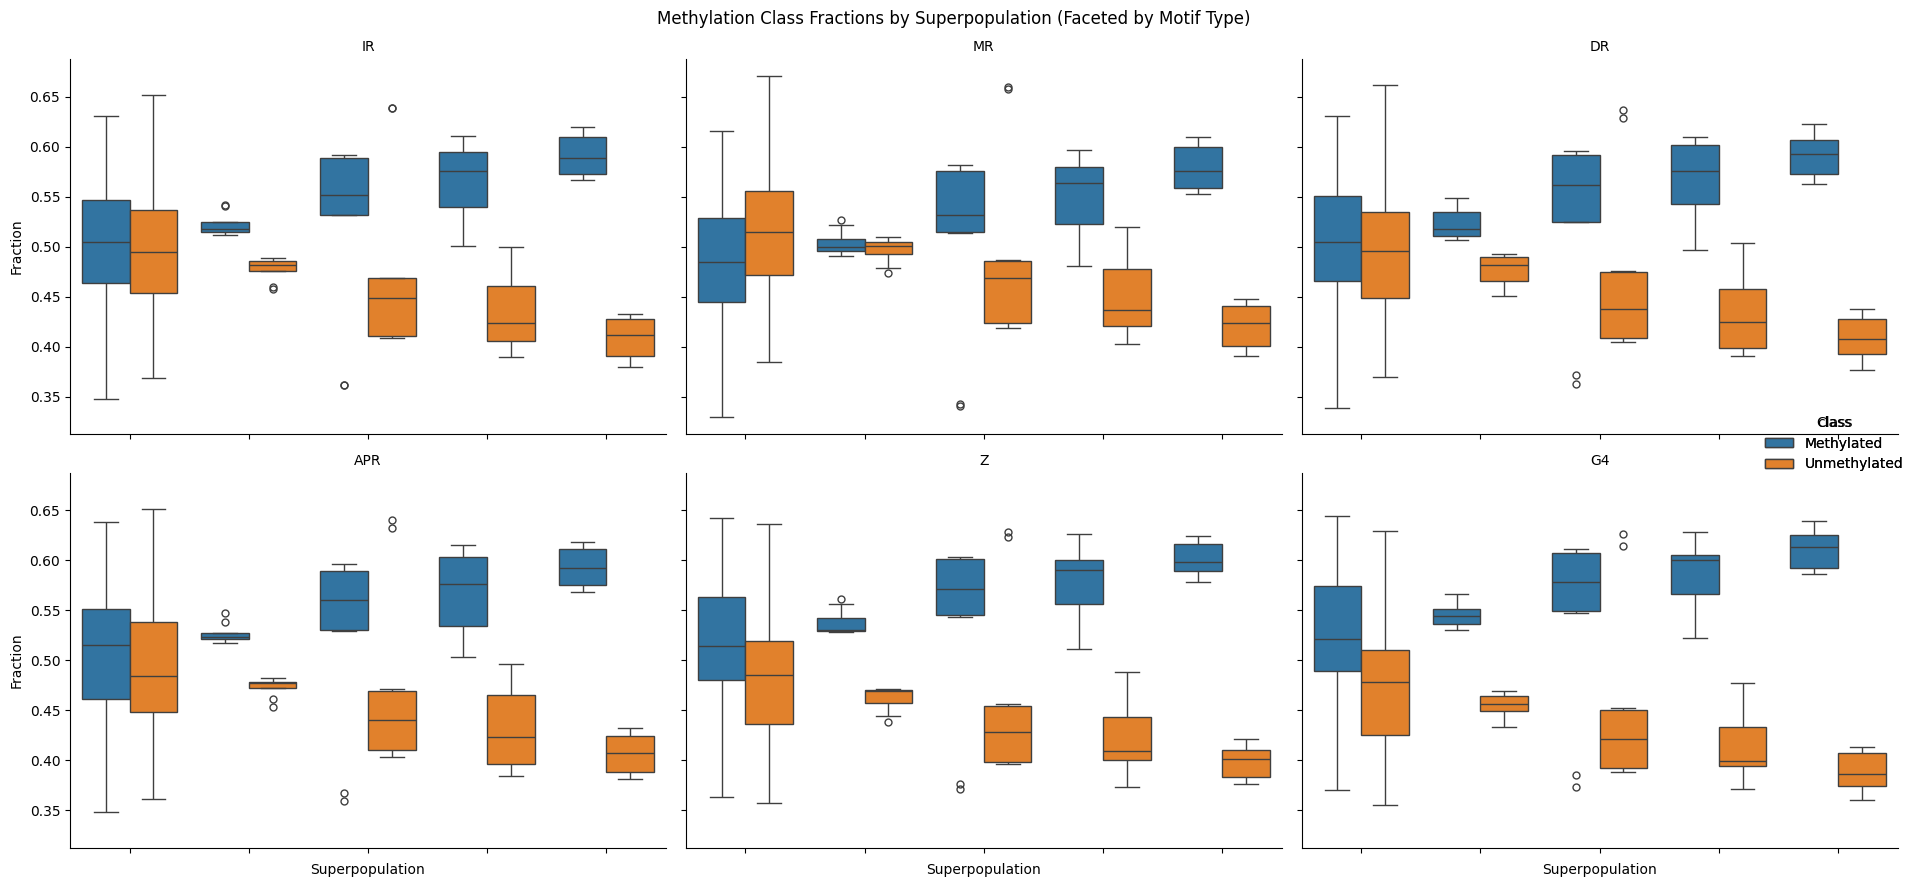

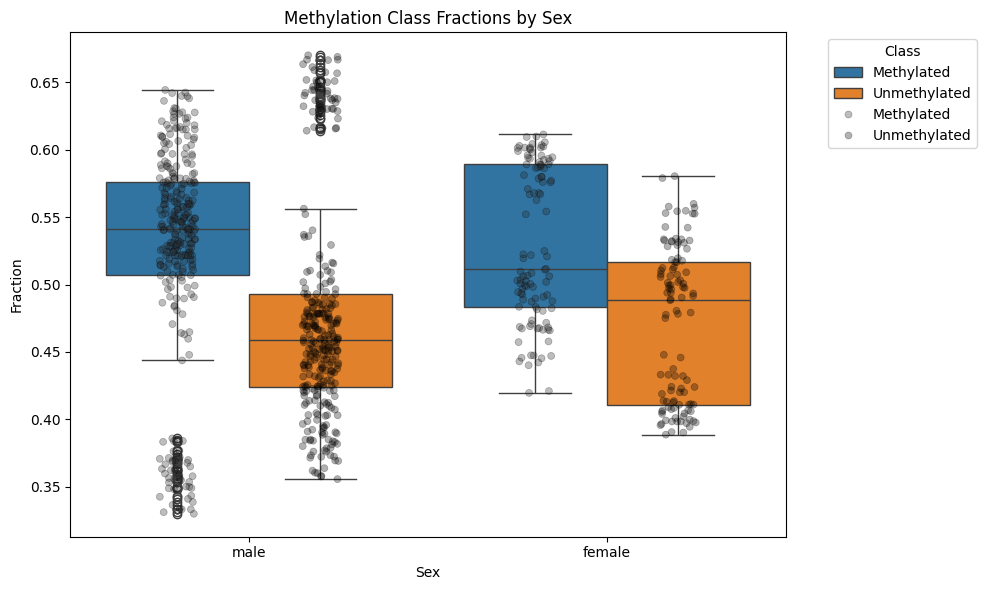

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === Step 1: Load methylation CSV
meth_file = "/home/alextu/projects/def-sushant/alextu/PhasedHapAssembly-nonB/analysis_scripts/haplotype_methylation_percentages.csv"
meth_df = pd.read_csv(meth_file)

# Extract sample ID (e.g., HG01890 from HG01890_hap1)
meth_df["sample"] = meth_df["haplotype"].str.extract(r"(HG\d+|NA\d+)")

# === Step 2: Load metadata TSV
meta_file = "/home/alextu/scratch/igsr_samples.tsv"
meta_df = pd.read_csv(meta_file, sep="\t")
meta_df.rename(columns={"Sample name": "sample"}, inplace=True)

# === Step 3: Merge on sample
merged = pd.merge(meth_df, meta_df, on="sample", how="inner")

# === Step 4: Plot methylation fractions by superpopulation
plt.figure(figsize=(12, 6))
sns.boxplot(data=merged, x="Superpopulation name", y="fraction", hue="class", dodge=True)
sns.stripplot(data=merged, x="Superpopulation name", y="fraction", hue="class", palette='dark:black',
              dodge=True, jitter=True, alpha=0.3, color='black', linewidth=0.5)
plt.xticks(rotation=45)
plt.title("Methylation Class Fractions by Superpopulation")
plt.ylabel("Fraction")
plt.xlabel("Superpopulation")
plt.legend(title="Class", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# ✅ === NEW: Boxplot of methylation class fractions per superpopulation, FACETED by motif
g = sns.catplot(
    data=merged,
    x="Superpopulation name", y="fraction", hue="class",
    col="motif_type", kind="box", dodge=True,
    col_wrap=3, height=4.5, aspect=1.2,
    showfliers=True
)
g.set_titles("{col_name}")
g.set_axis_labels("Superpopulation", "Fraction")
g.set_xticklabels(rotation=45)
g.add_legend(title="Class")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Methylation Class Fractions by Superpopulation (Faceted by Motif Type)")
plt.tight_layout()
plt.show()

# === Final: Methylation class fractions by Sex
plt.figure(figsize=(10, 6))
sns.boxplot(data=merged, x="Sex", y="fraction", hue="class", dodge=True)
sns.stripplot(data=merged, x="Sex", y="fraction", hue="class", palette='dark:black',
              dodge=True, jitter=True, alpha=0.3, color='black', linewidth=0.5)
plt.title("Methylation Class Fractions by Sex")
plt.xlabel("Sex")
plt.ylabel("Fraction")
plt.legend(title="Class", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

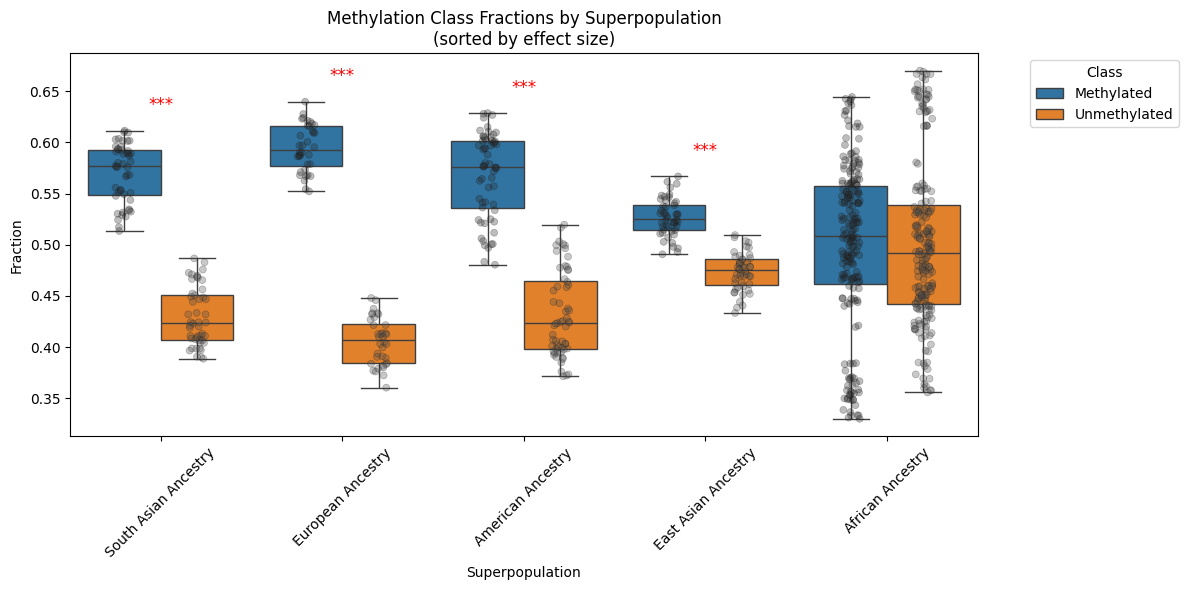

        Superpopulation       p_value  effect_size
2  South Asian Ancestry  3.234613e-17     1.000000
4     European Ancestry  3.046341e-13     1.000000
3     American Ancestry  2.849329e-20     0.976667
1   East Asian Ancestry  2.642246e-16     0.970486
0      African Ancestry  3.640867e-01     0.052100


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
import numpy as np

# === Step 1: Load methylation CSV
meth_file = "/home/alextu/projects/def-sushant/alextu/PhasedHapAssembly-nonB/analysis_scripts/haplotype_methylation_percentages.csv"
meth_df = pd.read_csv(meth_file)

# Extract sample ID (e.g., HG01890 from HG01890_hap1)
meth_df["sample"] = meth_df["haplotype"].str.extract(r"(HG\d+|NA\d+)")

# === Step 2: Load metadata TSV
meta_file = "/home/alextu/scratch/igsr_samples.tsv"
meta_df = pd.read_csv(meta_file, sep="\t")
meta_df.rename(columns={"Sample name": "sample"}, inplace=True)

# === Step 3: Merge and remove HG03009
merged = pd.merge(meth_df, meta_df, on="sample", how="inner")
merged = merged[merged["sample"] != "HG03009"]

# === Step 4: Mann-Whitney test + effect size (rank-biserial correlation)
results = []
for pop in merged["Superpopulation name"].unique():
    sub = merged[merged["Superpopulation name"] == pop]
    methylated = sub[sub["class"] == "Methylated"]["fraction"]
    unmethylated = sub[sub["class"] == "Unmethylated"]["fraction"]

    if len(methylated) > 0 and len(unmethylated) > 0:
        stat, p = mannwhitneyu(methylated, unmethylated, alternative="two-sided")
        # Rank-biserial correlation = (U / (n1*n2)) * 2 - 1
        n1, n2 = len(methylated), len(unmethylated)
        rank_biserial = (stat / (n1 * n2)) * 2 - 1
        results.append((pop, p, rank_biserial))

# Create sorted list of populations by effect size magnitude
results_df = pd.DataFrame(results, columns=["Superpopulation", "p_value", "effect_size"])
results_df["abs_effect_size"] = results_df["effect_size"].abs()
sorted_pops = results_df.sort_values("abs_effect_size", ascending=False)["Superpopulation"].tolist()

# Add significance label
def get_sig_label(p):
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return "ns"

# === Step 5: Plot
plt.figure(figsize=(12, 6))
ax = sns.boxplot(data=merged, x="Superpopulation name", y="fraction", hue="class",
                 dodge=True, order=sorted_pops)

sns.stripplot(data=merged, x="Superpopulation name", y="fraction", hue="class",
              dodge=True, jitter=True, alpha=0.3, linewidth=0.5,
              order=sorted_pops, palette="dark:.3")

# Add significance annotations manually
for i, row in results_df.set_index("Superpopulation").loc[sorted_pops].iterrows():
    pop = i
    p = row["p_value"]
    label = get_sig_label(p)
    if label != "ns":
        y_max = merged[merged["Superpopulation name"] == pop]["fraction"].max()
        ax.text(sorted_pops.index(pop), y_max + 0.02, label, ha='center', fontsize=12, color='red')

# Final formatting
plt.xticks(rotation=45)
plt.title("Methylation Class Fractions by Superpopulation\n(sorted by effect size)")
plt.xlabel("Superpopulation")
plt.ylabel("Fraction")
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[:2], labels[:2], title="Class", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Print summary table
print(results_df.sort_values("abs_effect_size", ascending=False).drop(columns="abs_effect_size"))

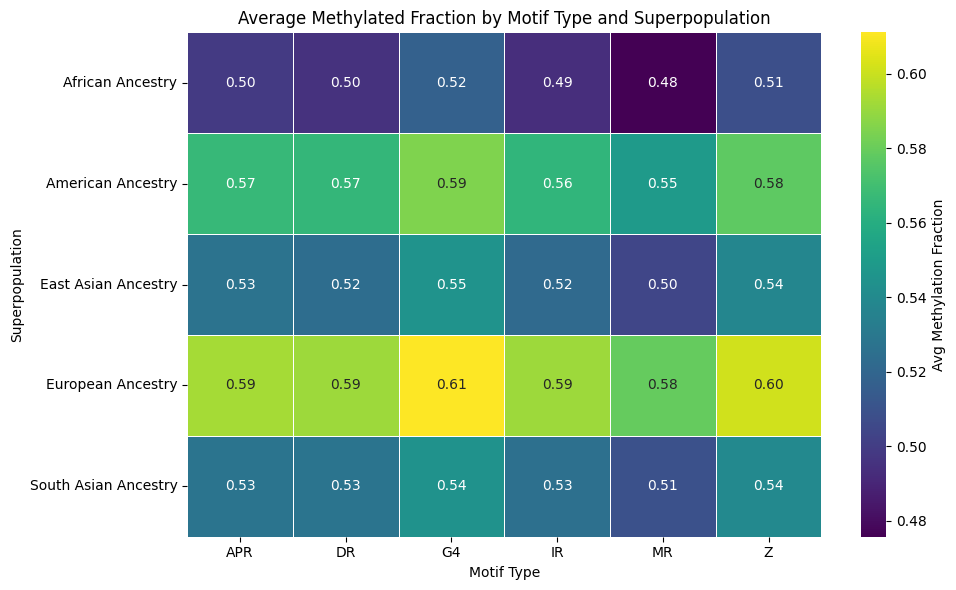

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# === Load data ===
meth_df = pd.read_csv("/home/alextu/projects/def-sushant/alextu/PhasedHapAssembly-nonB/analysis_scripts/haplotype_methylation_percentages.csv")
meta_df = pd.read_csv("/home/alextu/scratch/igsr_samples.tsv", sep="\t")

# === Preprocessing ===
meth_df["haplotype"] = meth_df["haplotype"].str.strip()
meth_df["sample"] = meth_df["haplotype"].str.extract(r"(HG\d+|NA\d+)")

meta_df.rename(columns={"Sample name": "sample"}, inplace=True)
meta_df["sample"] = meta_df["sample"].str.strip()
meta_df["Superpopulation name"] = meta_df["Superpopulation name"].str.strip()

# === Merge metadata
merged = pd.merge(meth_df, meta_df, on="sample", how="left")

# === Filter methylated class
meth_m = merged[merged["class"] == "Methylated"].copy()

# === Compute average methylation per motif × ancestry
summary_df = meth_m.groupby(["Superpopulation name", "motif_type"])["fraction"].mean().reset_index()

# === Pivot to heatmap format
heatmap_data = summary_df.pivot(index="Superpopulation name", columns="motif_type", values="fraction").fillna(0)

# === Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".2f",
    cmap="viridis",
    linewidths=0.5,
    cbar_kws={"label": "Avg Methylation Fraction"}
)
plt.title("Average Methylated Fraction by Motif Type and Superpopulation")
plt.ylabel("Superpopulation")
plt.xlabel("Motif Type")
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

# === Load input
df = pd.read_csv("/home/alextu/scratch/filtered_hotspots_G4_50percent.tsv", sep="\t")

# === Define thresholds
high_threshold = 0.9
low_threshold = 0.3

# === Get ancestry names from fraction columns
fraction_cols = [col for col in df.columns if col.endswith("_fraction")]
ancestries = [col.replace("_fraction", "") for col in fraction_cols]

# === Identify regions with one dominant ancestry
dominant_rows = []

for idx, row in df.iterrows():
    high = []
    low = []
    for anc in ancestries:
        frac = row[f"{anc}_fraction"]
        if frac >= high_threshold:
            high.append(anc)
        elif frac <= low_threshold:
            low.append(anc)
    
    # Keep if exactly one high ancestry and all others are low
    if len(high) == 1 and len(low) == (len(ancestries) - 1):
        dominant_rows.append({
            "Chromosome": row["Chromosome"],
            "Start": row["Start"],
            "End": row["End"],
            "Dominant_Ancestry": high[0],
            **{f"{anc}_fraction": row[f"{anc}_fraction"] for anc in ancestries}
        })

# === Save results
dominant_df = pd.DataFrame(dominant_rows)
dominant_df.head()

In [4]:
import pandas as pd

# === Load input
df = pd.read_csv("/home/alextu/scratch/filtered_hotspots_G4_50percent.tsv", sep="\t")

# === Identify ancestry fraction columns
fraction_cols = [col for col in df.columns if col.endswith("Ancestry_fraction")]
ancestries = [col.replace(" Ancestry_fraction", "") for col in fraction_cols]

# === Find one region per ancestry where:
#     1. It's the max fraction in the row
#     2. It's at least 0.5 higher than all other ancestries
top_regions = []

for anc in ancestries:
    col = f"{anc} Ancestry_fraction"
    
    for idx, row in df.iterrows():
        row_fractions = {a: row[f"{a} Ancestry_fraction"] for a in ancestries}
        max_anc = max(row_fractions, key=row_fractions.get)

        if max_anc != anc:
            continue

        dominant_value = row_fractions[anc]
        margin_ok = all(
            (dominant_value - row_fractions[other]) > 0.6
            for other in ancestries if other != anc
        )

        if margin_ok:
            region = {
                "Ancestry": anc,
                "Chromosome": row["Chromosome"],
                "Start": int(row["Start"]),
                "End": int(row["End"]),
                "Motif": row["Motif"],
                "Max_Fraction": dominant_value
            }
            for other_anc in ancestries:
                region[f"{other_anc}_fraction"] = row[f"{other_anc} Ancestry_fraction"]
            top_regions.append(region)
            break  # only take first valid region per ancestry

# === Output
top_df = pd.DataFrame(top_regions)
print(top_df)

   Ancestry Chromosome      Start        End Motif  Max_Fraction  \
0  European       chr1  163800000  163900000    G4      0.833333   

   African_fraction  American_fraction  East Asian_fraction  \
0          0.205882                0.2                0.125   

   European_fraction  South Asian_fraction  
0           0.833333                   0.2  
